<a href="https://colab.research.google.com/github/jjiho/20141001-Lee-Jiho/blob/master/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   4831      0 --:--:-- --:--:-- --:--:--  4817
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 337.3MB 46kB/s 
+ set +ex
Installation succeeded!


pip install cupy

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

from google.colab import drive
drive.mount('/content/gdrive')
file_data = "gdrive/My Drive/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = cp.sum(d)
    # r = cp.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = cp.empty(( num_image, size_row * size_col), dtype=float)
list_label  = cp.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = int(line_data[0])
    im_vector   = cp.array(np.asfarray(line_data[1:]))
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[count, : ]    = im_vector

    count += 1

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Mount datas from gdrive and save it as cupy array

In [0]:
data_train = list_image[ :1000, :]
data_testing = list_image[1000: , :]
label_train = list_label[ :1000]
label_testing = list_label[1000: ]

theta_u = cp.random.randn(785, 196)
theta_v = cp.random.randn(197, 49)
theta_w = cp.random.randn(50, 10)

data_y = cp.zeros(196)
data_z = cp.zeros(50)

def one_hot_labels(label):
  ret = cp.zeros((len(label), 10))
  for i in range(len(label)):
    ret[i][label[i]] = 1
  return ret

def sigmoid_prime(s) :
  return (sigmoid(s))*(1-sigmoid(s))
  
def bias(input_layer):
    input_layer = cp.array(np.insert(cp.asnumpy(input_layer), 0, 1, axis = 1))
    return input_layer

def sigmoid(s):
    return 1 / (1+cp.exp(-(s)))

label_train = one_hot_labels(label_train)
label_testing = one_hot_labels(label_testing)

In [0]:
def Objective_Function(input, input_test, theta_u, theta_v, theta_w, label_train, label_test, num_of_learning = 30000, learning_rate = 1.5, lamb = 30):
  loss_train = []
  loss_test = []
  acc_train = []
  acc_testing = []

  num_thetas = 785 * 196 + 197 * 49 + 50 * 10
  
  for i in range(num_of_learning):
    layer1 = cp.dot(bias(input), theta_u)
    sig_layer1 = bias(sigmoid(layer1))
    
    layer2 = cp.dot(sig_layer1, theta_v)
    sig_layer2 = bias(sigmoid(layer2))

    layer3 = cp.dot(sig_layer2, theta_w)
    sig_layer3 = sigmoid(layer3)

    layer1_t = cp.dot(bias(input_test), theta_u)
    sig_layer1_t = bias(sigmoid(layer1_t))

    layer2_t = cp.dot(sig_layer1_t, theta_v)
    sig_layer2_t = bias(sigmoid(layer2_t))

    layer3_t = cp.dot(sig_layer2_t, theta_w)
    sig_layer3_t = sigmoid(layer3_t)

    sum_theta = cp.sum(theta_u**2) + cp.sum(theta_v**2) + cp.sum(theta_w**2)

    loss_train.append(loss_function(sig_layer3, label_train, 1000, sum_theta, num_thetas, lamb))
    loss_test.append(loss_function(sig_layer3_t, label_test, 9000, sum_theta, num_thetas, lamb))

    acc_train.append(get_accuracy(sig_layer3, label_train, 1000))
    acc_testing.append(get_accuracy(sig_layer3_t, label_testing, 9000))

    part1 = ((1-label_train) / (1 - sig_layer3) - (label_train / sig_layer3)) * sigmoid_prime(layer3)
    
    gd_w = cp.dot(cp.transpose(part1), sig_layer2)
    part2 = cp.dot(part1, cp.transpose(theta_w[1:])) * sigmoid_prime(layer2)
    gd_v = cp.dot(cp.transpose(part2), sig_layer1)
    part3 = cp.dot(part2, cp.transpose(theta_v[1:])) *sigmoid_prime(layer1)
    gd_u = cp.dot(cp.transpose(part3), bias(input))


    theta_u = theta_u - learning_rate * (cp.transpose(gd_u) / 1000 + lamb * theta_u / num_thetas)
    theta_v = theta_v - learning_rate * (cp.transpose(gd_v) / 1000 + lamb * theta_v / num_thetas)
    theta_w = theta_w - learning_rate * (cp.transpose(gd_w) / 1000 + lamb * theta_w / num_thetas)

  return loss_train, loss_test, acc_train, acc_testing, theta_u, theta_v, theta_w, sig_layer3_t


def loss_function(h, label, num_data, sum_theta, num_thetas, lamb):
  ret = cp.zeros((num_data, 10))
  for i in range(0, 10):
    ret[:, i] = (-label[:, i]*cp.log(h[:, i]) - (1-label[:,i]) * cp.log(1-h[:, i])) + lamb * (sum_theta) / (2 * num_thetas)
  return cp.average(cp.sum(ret, axis=1))

def get_accuracy(h, label, num_data):
  answer = cp.argmax(h, axis=1)
  corrects = cp.argmax(label, axis=1)
  num_corrects = len(label[corrects==answer])
  return num_corrects/num_data*100


loss_train, loss_testing, acc_train, acc_testing, t_u, t_v, t_w, h_test = Objective_Function(data_train, data_testing, theta_u, theta_v, theta_w, label_train, label_testing)

In [0]:
prediction = cp.argmax(h_test, axis=1)
answer = cp.argmax(label_testing, axis = 1)

corrects = data_testing[prediction==answer]
corrects_label = prediction[prediction==answer]
incorrects = data_testing[prediction!=answer]
incorrects_label = prediction[prediction!=answer]

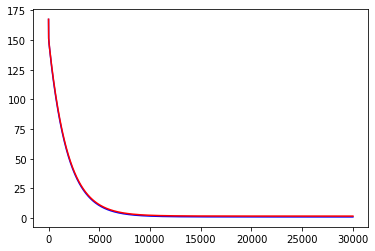

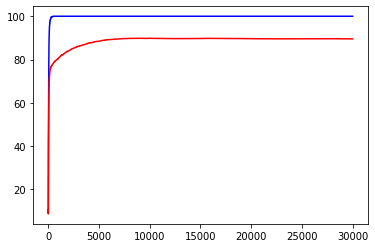

Accuracy for Training data(%) :  100.0
Accuracy for Testing data(%) 89.53333333333333


Correct :


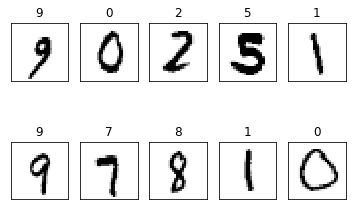



Incorrect : 


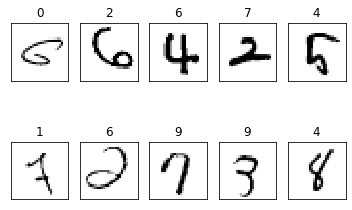

In [12]:
plt.plot(loss_train, color = 'blue')
plt.plot(loss_testing, color = 'red')
plt.show()

plt.plot(acc_train, color = 'blue')
plt.plot(acc_testing, color = 'red')
plt.show()

print("Accuracy for Training data(%) : ", acc_train[-1])
print("Accuracy for Testing data(%)", acc_testing[-1])

import random
print("\n\nCorrect :")
for i in range(10):
    label       = corrects_label[i]
    im_matrix   = corrects[i].reshape((size_row, size_col))

    plt.subplot(2, 5, i+1)
    plt.title(str(label))
    plt.imshow(cp.asnumpy(im_matrix), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()

print("\n\nIncorrect : ")
for i in range(10):
    label       = incorrects_label[i]
    im_matrix   = incorrects[i].reshape((size_row, size_col))

    plt.subplot(2, 5, i+1)
    plt.title(str(label))
    plt.imshow(cp.asnumpy(im_matrix), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()